In [1]:

# This is a file for testing performance of masque
# Run this file on three different machines
# change the variables: role, ip_dict
# Assign each machine a role 
#   and fill in ip address in ip_dict



# You can run these linux commands for setting up the environment
'''
cd ~
rm -rf ~/masque-linux
sudo git clone https://github.com/dx2102/masque-linux
cd ~/masque-linux
sudo chmod a+rwx -R .

code --install-extension ms-python.python
code --install-extension ms-toolsai.jupyter
code --install-extension github.copilot

sudo apt update
sudo apt install -y python3-pip libssl-dev
pip install aioquic ipykernel

sudo code ~/masque-linux
'''



'\ncd ~\nrm -rf ~/masque-linux\nsudo git clone https://github.com/dx2102/masque-linux\ncd ~/masque-linux\nsudo chmod a+rwx -R .\n\ncode --install-extension ms-python.python\ncode --install-extension ms-toolsai.jupyter\ncode --install-extension github.copilot\n\nsudo apt update\nsudo apt install -y python3-pip libssl-dev\npip install aioquic ipykernel\n\nsudo code ~/masque-linux\n'

In [2]:
# Imports, Utilities
import time
import os
import socket
import aioquic
import subprocess

def detect_ip():
    s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    s.connect(("google.com", 80))
    ip = s.getsockname()[0]
    s.close()
    return ip


def kill_process_on_port(port, wait=0.1):
    try:
        # 使用 lsof 命令查找监听指定端口的进程并获取其PID
        cmd = f"lsof -i :{port} -t"
        output = subprocess.check_output(cmd, shell=True)
        pids = output.decode('utf-8').split('\n')
        
        for pid in pids:
            if pid:
                pid = int(pid)
                # 终止进程
                subprocess.call(['kill', '-9', str(pid)])
                print(f"Terminated process with PID {pid}")
    except subprocess.CalledProcessError:
        print(f"No process found listening on port {port}")
    finally:
        time.sleep(wait)

for port in [4433, 12345]:
    kill_process_on_port(port)

No process found listening on port 4433


No process found listening on port 12345


In [3]:
from utils import local_ip
print("IP of this machine: ")
print(local_ip)

IP of this machine: 
10.209.87.65


In [4]:
# configs:
role = 'client'
assert role in ['client', 'proxy', 'echo']

ip_dict = {
    'client': local_ip,
    'proxy': 'ms0403.utah.cloudlab.us',
    'echo': 'ms0429.utah.cloudlab.us',
}
assert ip_dict[role] == local_ip

masque client started. Now trying handshake
ProtocolNegotiated(alpn_protocol='h3-29')
HandshakeCompleted(alpn_protocol='h3-29', early_data_accepted=False, session_resumed=False)
ConnectionIdIssued(connection_id=b'\xabF\xfd\x9eoo\x8b%')
Connected
sending connect-udp request
drop GREASE noise on stream 3
drop GREASE noise on stream 7
drop GREASE noise on stream 11
drop GREASE noise on stream 15
StreamDataReceived(data=b'\xf7\x8d\x82\x88\x9a\xd2A\xcc\x00\xd4\xe5d\xbe*L\x88\x84\x12GREASE is the word\x01\x03\x00\x00\xd9', end_stream=False, stream_id=12)


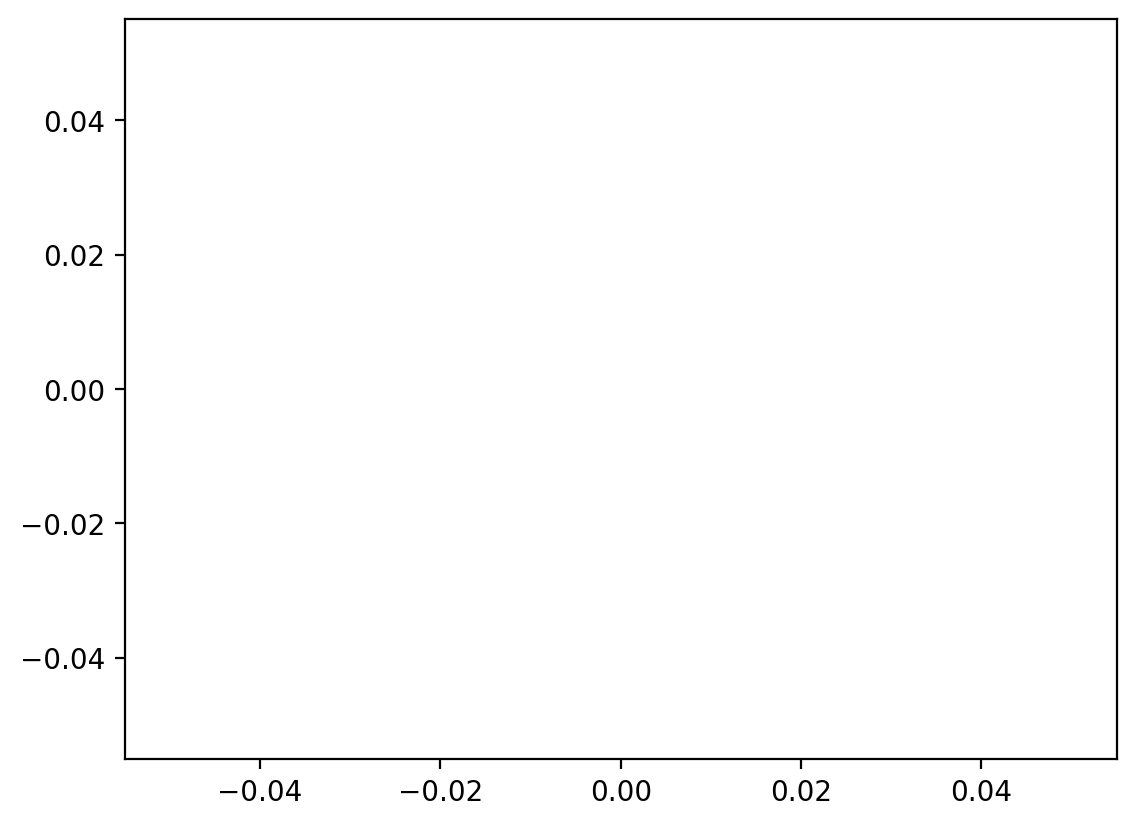

ConnectionTerminated(error_code=<QuicErrorCode.NO_ERROR: 0>, frame_type=None, reason_phrase='')


ZeroDivisionError: division by zero

In [5]:
# client:

from aioquic.quic.connection import QuicConnection
from aioquic.quic.configuration import QuicConfiguration
from aioquic.h3.connection import H3Connection
from aioquic.quic.events import QuicEvent

from aioquic.asyncio.client import connect
from aioquic.asyncio.protocol import QuicConnectionProtocol

import asyncio
import ssl

plot_count = 3
total_test_count = 100
gap_between_test = 1/10000
delays = {}

send_start_time = None
send_end_time = None

silent = True
def log(*args):
    if not silent:
        print(*args)

def plot_delays():
    import matplotlib.pyplot as plt
    %config InlineBackend.figure_format = 'retina'
    delays_lst = sorted(delays.items()) # sort by send_time
    delays_lst = [delay for (send_time, delay) in delays_lst] # get delay
    plt.plot(delays_lst)
    plt.show()
    print('average delay:', sum(delays_lst) / len(delays_lst))
    print('spent', send_end_time - send_start_time, 'seconds to send and receive',
          len(delays_lst), 'packets with gap', gap_between_test, 'seconds'
    )
    print('remaining packets to send', total_test_count - len(delays_lst))

class MasqueClient(QuicConnectionProtocol):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.h3 = H3Connection(self._quic)

    def quic_event_received(self, event: QuicEvent):
        # 由于我们在手动管理self.h3状态机，必须保证它能收到所有的QuicEvent
        self.h3.handle_event(event)
        # 打印所有event
        sort = event.__class__.__name__
        if sort == 'StreamDataReceived':
            if event.stream_id % 4 == 3:
                print('drop GREASE noise on stream', event.stream_id)
                return
        if sort == 'DatagramFrameReceived':
            send_time = float(event.data[2:].decode())
            delay = time.time() - send_time
            delays[send_time] = delay
            log('got echo packet with delay:', delay)
            global send_end_time
            send_end_time = time.time()
            # return
        print(event)
    
    async def test(self):
        print('sending connect-udp request')
        stream_id = self._quic.get_next_available_stream_id()
        stream_id = 4 * 3
        self.h3.send_headers(
            stream_id=stream_id,
            headers=[
                (b":method", b"CONNECT"), # 和一般的GET POST等不同，masque代理的特殊标记
                (b":protocol", b"connect-udp"), # 另一个特殊标记，表示要用udp不是tcp
                (b":path", f"/well-known/masque/{ ip_dict['echo'] }/12345".encode()), # 转发的目的地，实际上之后最后两个斜杠会被读取

                (b":authority", b"localhost"), # 代理服务器本身的地址，实际上并不会被masquerade检查
                (b":scheme", b"https"), # scheme允许在同一个连接中混用http和https，实际上也不会被masquerade检查
            ],
        )
        self.transmit()
        # 接下来要等待 200 OK，但是这里直接用sleep代替
        await asyncio.sleep(0.5)

        global send_start_time
        send_start_time = time.time()

        for i in range(plot_count):
            for j in range(total_test_count // plot_count):
                data = str(time.time()).encode()
                log('sending data to udp echo server:', data)
                flow_id = stream_id // 4
                self.h3.send_datagram(flow_id, b'\x00' + data)
                self.transmit()
                await asyncio.sleep(gap_between_test)
            await asyncio.sleep(0.1)
            plot_delays()
            await asyncio.sleep(0.1)

if role == 'client':
    print("masque client started. Now trying handshake")
    async with connect(
        ip_dict["proxy"], 4433, 
        create_protocol=MasqueClient,
        configuration=QuicConfiguration(
            is_client=True,
            verify_mode=ssl.CERT_NONE, # 不验证证书，所以可能会受到中间人攻击，但是后续的数据还是会加密的
            alpn_protocols=["h3-29"], # 使用h3-29草案的quic
            max_datagram_frame_size=1200, # 默认为None，只有设了值才会允许h3 datagram扩展
            # error!("Connection {} stream {} send failed {:?}", client.conn.trace_id(), to_send.stream_id, e);
            # eprintln!("dgram_enabled_by_peer: {:?}", http3_conn.dgram_enabled_by_peer(&mut client.conn));
            # 在masquerade中插入这一行，可以打印出masquerade认为我们是否支持h3 datagram
                            
        ),
    ) as client:
        print("Connected")
        await client.test()


In [ ]:
print(sum(delays))
print(len(delays))

17010029793699.191
9999


In [ ]:
# proxy:


if role == 'proxy':
    kill_process_on_port(4433)
    os.system('''
    cd ~/masque-linux
    export RUST_LOG=debug
    ./server 0.0.0.0:4433 &
    ''')


In [ ]:
# echo:
if True or role == 'echo':
    # to test echo server in command line:
    # nc -u localhost 12345
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.bind(('0.0.0.0', 12345))
    print('UDP echo server started')
    while True:
        data, addr = sock.recvfrom(1024)
        print('UDP echo server echoing: ', data)
        sock.sendto(data, addr)
    sock.close()

UDP echo server started
